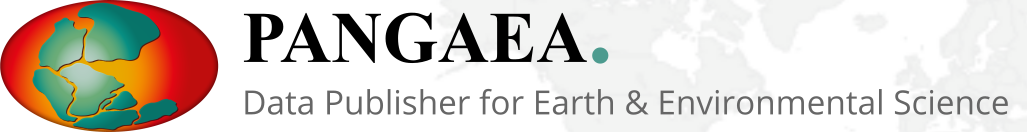

# **How to retrieve data from PANGAEA**

Version: 0.0.2<br>
By: Michael Oellermann, Kathrin Riemann-Campe<br>
Last updated: 2023-05-10

This notebook will guide you how to retrieve diverse earth- and environmental data and its metadata from the [PANGAEA data repository](https://www.pangaea.de) using Python. It uses the [PangaeaPy package](https://github.com/pangaea-data-publisher/pangaeapy), to facilitate the data download.

Run this notebook in:
* [GoogleColab](https://colab.requery.google.com/github/pangaea-data-publisher/community-workshop-material/blob/master/Python/Get_pangaea_data/get_pangaea_data.ipynb): <a target="_blank" href="https://colab.requery.google.com/github/pangaea-data-publisher/community-workshop-material/blob/master/Python/Get_pangaea_data/get_pangaea_data.ipynb">
  <img src="https://colab.requery.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# 1. Import libraries

In [106]:
import os
import pandas as pd
import openpyxl

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

# Pangaeapy
#!pip install pangaeapy # Uncomment to install pangaeapy
import pangaeapy as pan
from pangaeapy.pandataset import PanDataSet

# Web scraping
from bs4 import BeautifulSoup
from urllib.request import urlopen, urlretrieve
import json
from pandas import json_normalize

# To access genebank records
#!pip install biopython # To install biopython library
from Bio import Entrez
from Bio import SeqIO
Entrez.email = "your_email@example.com"

# 2. Query for data in PANGAEA

AIM: What data can I find for a particular topic such as a species, location or author?

This mirrors the query via the [PANGAEA website](https://pangaea.de/)

## 2.1 Simple query
Note:
* limit = the total number of datasets to be returned from query is 500.
    * To download > 500 use the offset attribute e.g. pan.PanQuery("Triticum", limit = 500, offset=500)
* type: child = data set as part of a data collection, parent = data collection
* score: Indicates how well the dataset matched the query term

In [107]:
# query database for Helgoland Roads
query = pan.PanQuery("Triticum")
print(f'There have been {query.totalcount} query results')
# Save query as dataframe
query_results = pd.DataFrame(query.result)
query_results.head(4)

There have been 591 query results


,URI,score,html,type,position
0,doi:10.1594/PANGAEA.896784,20.516336,"<li><div class=""citation""><a href=""https://doi...",parent,0
1,doi:10.1594/PANGAEA.886727,18.917500,"<li><div class=""citation""><a href=""https://doi...",child,1
2,doi:10.1594/PANGAEA.925261,18.778510,"<li><div class=""citation""><a href=""https://doi...",parent,2
3,doi:10.1594/PANGAEA.886725,18.592623,"<li><div class=""citation""><a href=""https://doi...",child,3


## 2.2 More complex queries

[More information](https://wiki.pangaea.de/wiki/PANGAEA_query) how to query with keywords


Multiple query terms

In [108]:
# Finds datasets that contain both "marine" and "geology"
query = pan.PanQuery("marine geology")
print(f'There have been {query.totalcount} query results')

There have been 45139 query results


Optional query terms

In [109]:
# Find datasets that contain "Globigerina" and either "falconensis" or "bulloides" 
query = pan.PanQuery("Globigerina AND (falconensis OR bulloides)")
print(f'There have been {query.totalcount} query results')

There have been 6398 query results


Uncertain spelling

In [110]:
# Finds datasets with "Neogloboquadrina" regardless of your spelling mistake
query = pan.PanQuery("~Neogloboqadrina")
print(f'There have been {query.totalcount} query results') 

There have been 4946 query results


Specific author

In [111]:
#  	Finds datasets of author "Herzschuh"
query = pan.PanQuery("author:Herzschuh")
print(f'There have been {query.totalcount} query results') 

There have been 511 query results


Within geolocation

In [112]:
# query database for "Deep-sea Sponge Microbiome Project" within a certain geolocation
query = pan.PanQuery("Deep-sea Sponge Microbiome Project", limit = 500, bbox=(17.7, 67.7, 21, 69))
print(f'There have been {query.totalcount} query results')

There have been 2 query results


## 2.3 Queries exceeding 500 results

### Function to query Pangaea without limited results

In [113]:
# Function to query pangaea for datasets
# This function overcomes the limit of 500 datasets
def query_pangaea(query_term = "", limit = 500, exclude_collection = True):
    query = pan.PanQuery(query_term, limit = limit)
    print(f'{query.totalcount} total query results. Query limited to {limit} results.')

    # Save query as dataframe
    query_results = pd.DataFrame(query.result)
    
    # Constrain query to limit
    if limit:
        query.totalcount = limit

    # if more than 500 query increase the offset to overcome data download limit
    if query.totalcount > 500:
        for offset in range(500, int(query.totalcount), 500):
            # new query with increased offset
            query = pan.PanQuery(query_term, offset=offset, limit = 500)
            # Attach further query results
            query_results = pd.concat([query_results, pd.DataFrame(query.result)])

    # Exclude data collection (parents) if true
    if exclude_collection:        
        query_results = query_results[query_results.type == "child"]
        print(f'{len(query_results)} child datasets extracted')

    # Delete redundant columns
    query_results = query_results.drop(["html", "position"], axis = 1)
    # Rename URI to doi
    query_results.rename(columns={"URI": "doi"})
    
    return query_results.reset_index(drop=True)

Perform query

In [114]:
# Perform PANGAEA query
query_term = "citation:author:Herzschuh"
query_results = query_pangaea(query_term, limit = 50, exclude_collection=True)
query_results.head(2)

424 total query results. Query limited to 50 results.
15 child datasets extracted


,URI,score,type
0,doi:10.1594/PANGAEA.856729,20.620167,child
1,doi:10.1594/PANGAEA.856782,20.616695,child


### Add Pangaea ID (optional for labeling)

In [86]:
# Function to extract and add pangaea ID to query result dataframe
def add_pangaea_id(query_df):
    # Extract PANGAEA dataset ID
    if "pangaea_id" not in query_df.columns:
        return query_df.insert(0, "pangaea_id", [int(id.split(".")[-1:][0]) for id in query_df.URI])

# Add pangaea dataset ids
add_pangaea_id(query_results)
query_results.head(2)

,pangaea_id,URI,score,type
0,856729,doi:10.1594/PANGAEA.856729,20.620167,child
1,856782,doi:10.1594/PANGAEA.856782,20.616695,child


# 3. Download datasets

## 3.1 Download single dataset

AIM: How can I download a single dataset right into Python or onto my harddrive?

### Seach for datasets

In [115]:
# Perform PANGAEA query
query_term = "Deep-sea Sponge Microbiome Project"
query_results = query_pangaea(query_term, limit = 50, exclude_collection=True)
# Add pangaea dataset ids
add_pangaea_id(query_results)
query_results.head(2)

8 total query results. Query limited to 50 results.
8 child datasets extracted


,URI,score,type
0,doi:10.1594/PANGAEA.923035,218.77216,child
1,doi:10.1594/PANGAEA.923033,212.82925,child


### Download dataset from PANGAEA
Dataset: https://doi.pangaea.de/10.1594/PANGAEA.923033

Using the full url

In [116]:
ds = PanDataSet("https://doi.pangaea.de/10.1594/PANGAEA.923033")
print(ds.data.head(3))

          Event        ID      Project      Access no gen Access no gen_2   
0  HUD16/19_010  WB-00001  PRJNA613976  insdc:SRR11365522             NaN  \
1  HUD16/19_010  WB-00005  PRJNA613976  insdc:SRR11365520             NaN   
2  HUD16/19_010  WB-00007  PRJNA613976  insdc:SRR11365519             NaN   

         Campaign  Date/Time  Latitude  Longitude  Depth water  ... Samp type   
0  Hudson2016-019 2016-01-01   44.3193    -62.605          199  ...    sponge  \
1  Hudson2016-019 2016-01-01   44.3193    -62.605          199  ...    sponge   
2  Hudson2016-019 2016-01-01   44.3193    -62.605          199  ...    sponge   

  Samp type_2                                            URL ref    Phylum   
0   LMA_glass  https://www.marinespecies.org/aphia.php?p=taxd...  Porifera  \
1   LMA_glass  https://www.marinespecies.org/aphia.php?p=taxd...  Porifera   
2   LMA_glass  https://www.marinespecies.org/aphia.php?p=taxd...  Porifera   

            Class          Order       Family    Genu

Using the doi

In [89]:
ds = PanDataSet("doi:10.1594/PANGAEA.923033")
print(ds.data.head(3))

          Event        ID      Project      Access no gen Access no gen_2   
0  HUD16/19_010  WB-00001  PRJNA613976  insdc:SRR11365522             NaN  \
1  HUD16/19_010  WB-00005  PRJNA613976  insdc:SRR11365520             NaN   
2  HUD16/19_010  WB-00007  PRJNA613976  insdc:SRR11365519             NaN   

         Campaign  Date/Time  Latitude  Longitude  Depth water  ... Samp type   
0  Hudson2016-019 2016-01-01   44.3193    -62.605          199  ...    sponge  \
1  Hudson2016-019 2016-01-01   44.3193    -62.605          199  ...    sponge   
2  Hudson2016-019 2016-01-01   44.3193    -62.605          199  ...    sponge   

  Samp type_2                                            URL ref    Phylum   
0   LMA_glass  https://www.marinespecies.org/aphia.php?p=taxd...  Porifera  \
1   LMA_glass  https://www.marinespecies.org/aphia.php?p=taxd...  Porifera   
2   LMA_glass  https://www.marinespecies.org/aphia.php?p=taxd...  Porifera   

            Class          Order       Family    Genu

Using the PANGAEA ID

In [90]:
ds = PanDataSet(923033)
print(ds.data.head(3))

          Event        ID      Project      Access no gen Access no gen_2   
0  HUD16/19_010  WB-00001  PRJNA613976  insdc:SRR11365522             NaN  \
1  HUD16/19_010  WB-00005  PRJNA613976  insdc:SRR11365520             NaN   
2  HUD16/19_010  WB-00007  PRJNA613976  insdc:SRR11365519             NaN   

         Campaign  Date/Time  Latitude  Longitude  Depth water  ... Samp type   
0  Hudson2016-019 2016-01-01   44.3193    -62.605          199  ...    sponge  \
1  Hudson2016-019 2016-01-01   44.3193    -62.605          199  ...    sponge   
2  Hudson2016-019 2016-01-01   44.3193    -62.605          199  ...    sponge   

  Samp type_2                                            URL ref    Phylum   
0   LMA_glass  https://www.marinespecies.org/aphia.php?p=taxd...  Porifera  \
1   LMA_glass  https://www.marinespecies.org/aphia.php?p=taxd...  Porifera   
2   LMA_glass  https://www.marinespecies.org/aphia.php?p=taxd...  Porifera   

            Class          Order       Family    Genu

### Translate to long parameter names
Because by default parameters are abbreviated without units

In [117]:
# Translate short parameters names to long names including unit
def get_long_parameters(ds):
    """Translate short parameters names to long names including unit

    Args:
        ds (PANGAEA dataset): PANGAEA dataset
    """
    ds.data.columns =  [f'{param.name} [{param.unit}]' if param.unit else param.name for param in ds.params.values()]

print(ds.data.columns[:10])
get_long_parameters(ds)
ds.data.columns[:10]

Index(['Event', 'ID', 'Project', 'Access no gen', 'Access no gen_2',
       'Campaign', 'Date/Time', 'Latitude', 'Longitude', 'Depth water'],
      dtype='object')


Index(['Event label', 'Identification', 'Project',
       'Accession number, genetics', 'Accession number, genetics', 'Campaign',
       'DATE/TIME', 'LATITUDE', 'LONGITUDE', 'DEPTH, water [m]'],
      dtype='object')

### Display location of dataset samples

In [118]:
# Plot sampling points on interactive plotly map
fig = px.scatter_mapbox(ds.data, lat="LATITUDE", lon="LONGITUDE", 
                        hover_name="Event label", 
                        hover_data=['LATITUDE', 'LONGITUDE', 'DEPTH, water [m]', 'Species', 'Gear'], 
                        zoom=0, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Save data

In [119]:
# Create data folder
data_folder = "pangaea_data"
# Check if it already exists before creating it
if not os.path.isdir(data_folder):
    os.mkdir(data_folder)
# Save to csv
print(f'PANGAEA dataset {ds.id} saved')
ds.data.to_csv(os.path.join(data_folder, f'Pangaea_dataset_{ds.id}.csv'))

PANGAEA dataset 923033 saved


## 3.2 Download multiple datasets

AIM: How can I download multiple datasets right into Python or on my harddrive?

### Perform query

In [120]:
# Perform PANGAEA query
query_term = "Deep-sea Sponge Microbiome Project"
query_results = query_pangaea(query_term, limit = 50, exclude_collection=True)
query_results.head(2)

8 total query results. Query limited to 50 results.
8 child datasets extracted


,URI,score,type
0,doi:10.1594/PANGAEA.923035,218.77216,child
1,doi:10.1594/PANGAEA.923033,212.82925,child


### Download multiple datasets
Note: 
* Data collections and restricted datasets cannot be downloaded

In [95]:
# Add pangaea dataset ids
add_pangaea_id(query_results)

# Create dictionary to store dataframes in
data_dict = {}
# Loop over IDs and download datasets
for pangaea_id in query_results.pangaea_id[:4]:
    print("".join(40*["-"]))
    print(f'Pangaea ID: {pangaea_id}')
    # Cache
    ds = PanDataSet(pangaea_id, enable_cache=True)
    # Translate to long parameter names
    get_long_parameters(ds)
    print(f'Dataset title: {ds.title}')
    print(ds.data.head(2))
    data_dict[pangaea_id] = ds.data

----------------------------------------
Pangaea ID: 923035
Dataset title: CTD profiles of the global Deep-sea Sponge Microbiome Project
    Event label    Profile    Station label  LATITUDE  LONGITUDE   
0  HUD16/19_392  seawater1  HUD16019_CON392   44.3182   -62.6062  \
1  HUD16/19_392  seawater1  HUD16019_CON392   44.3182   -62.6062   

   Pressure, water [dbar]  Temperature, water [°C]  Salinity  Elevation [m]   
0                      20                   6.2924     31.49         -203.4  \
1                      21                   6.0019     31.51         -203.4   

   Date/Time  
0 2016-01-01  
1 2016-01-01  
----------------------------------------
Pangaea ID: 923033
Dataset title: Metadata and NCBI-Accession numbers of the global Deep-sea Sponge Microbiome Project
    Event label Identification      Project Accession number, genetics   
0  HUD16/19_010       WB-00001  PRJNA613976          insdc:SRR11365522  \
1  HUD16/19_010       WB-00005  PRJNA613976          insdc:SRR11365

### Save multiple datasets

In [96]:
# Create data folder
data_folder = "pangaea_data"
if not os.path.isdir(data_folder):
    os.mkdir(data_folder)
# Loop over each dataset in the dictionary and save to csv
for key, df in data_dict.items():
    print(f'PANGAEA dataset {key} saved')
    # Save to csv
    data_dict[key].to_csv(os.path.join(data_folder, f'Pangaea_dataset_{key}.csv'))

PANGAEA dataset 923035 saved
PANGAEA dataset 923033 saved
PANGAEA dataset 923271 saved
PANGAEA dataset 909246 saved


# 4. Get metadata

## 4.1 Get metadata for each dataset

#### Download dataset

In [97]:
# Download dataset from PANGAEA
ds = PanDataSet(923033, include_data=False)
ds.data

""


### Basic metadata retrieval

In [98]:
# Title
print(f'Title: {ds.title}')
# Abstract
print(f'Abstract: {ds.abstract}')
# Publication date
print(f'Publication date: {ds.date}')
# Authors
print(f'Authors: {"; ".join([x.fullname for x in ds.authors])}')
# Author orcids
print(f'Orcids: {"; ".join([x.ORCID if x.ORCID else "no ORCID" for x in ds.authors])}')
# Citation
print(f'Citation: {ds.citation}')
# doi
print(f'doi: {ds.doi}')
# Geolocation
print(f'Latitude: {ds.geometryextent["meanLatitude"]}')
print(f'Longitude: {ds.geometryextent["meanLongitude"]}')
# Parameters
params = "; ".join([f'{param.name} [{param.unit}]' if param.unit else param.name for param in ds.params.values()])
print(f'Parameters: {params}')
# Event devices
print(f'Event devices: {"; ".join(set([device for device in ds.getEventsAsFrame()["device"]]))}')

Title: Metadata and NCBI-Accession numbers of the global Deep-sea Sponge Microbiome Project
Abstract: The Deep-sea Sponge Microbiome Project is a large-scale study, integrating 16S amplicon sequencing data of seawater, sediment, and sponges, with a large set of ecological and physical metadata. The present dataset includes NCBI-accession numbers, sample collection details, and diverse measurements, adding up to 50 entries for each of the 1546 covered samples.
Publication date: 2022-07-27T14:38:45
Authors: Busch, Kathrin; Hentschel, Ute
Orcids: 0000-0001-7621-998X; 0000-0003-0596-790X
Citation: Busch, Kathrin; Hentschel, Ute (2022): Metadata and NCBI-Accession numbers of the global Deep-sea Sponge Microbiome Project. PANGAEA, https://doi.org/10.1594/PANGAEA.923033
doi: https://doi.org/10.1594/PANGAEA.923033
Latitude: 42.626109120310446
Longitude: 158.91634702457935
Parameters: Event label; Identification; Project; Accession number, genetics; Accession number, genetics; Campaign; DATE/TI

## 4.2 Getting metadata for multiple datasets

### 4.2.1 Using Pangaeapy

#### Function to extract PANGAEA metadata

In [99]:
# Function to extract metadata from Pangaea dataset
def get_pangaea_meta(pangaea_id):
    try:
        print(f'Extract metadata for Pangaea ID: {pangaea_id}')
        # Get metadata for pangaea dataset
        ds = pan.PanDataSet(pangaea_id, enable_cache=True, include_data=False)
        # Create data frame to store metadata
        meta = pd.DataFrame({"pangaea_id": [pangaea_id]})
        # Extract and add metadata    
        meta["year"] = ds.year
        meta["authors"] = "; ".join([x.fullname for x in ds.authors])
        meta["title"] = ds.title
        meta["abstract"] = ds.abstract 
        meta["citation"] = ds.citation
        meta["parameters"]= "; ".join([f'{param.name} [{param.unit}]' if param.unit else param.name for param in ds.params.values()])
        meta["publication_date"] = ds.date
        # Check if there are geometry metadata
        if ds.geometryextent:
            meta["mean_latitude"] = ds.geometryextent["meanLatitude"]
            meta["mean_longitude"] = ds.geometryextent["meanLongitude"]
        # Check if events are available
        if not ds.getEventsAsFrame().empty:   
            meta["events"] = "; ".join(ds.getEventsAsFrame()["label"])
            meta["event_device"] = ds.getEventsAsFrame()["device"]
            meta["elevation"] = ds.getEventsAsFrame()["elevation"]
            meta["campaign"] = ds.getEventsAsFrame()["campaign"]
            meta["location"] = ds.getEventsAsFrame()["location"]
        meta["doi"] = ds.doi
        meta["datastatus"] = ds.datastatus
    except AttributeError:
        meta = pd.DataFrame()
    
    return meta

#### Function to download metadata from multiple datasets

In [100]:
# Function to download multiple Pangaea metadata
def get_pangaea_meta_df(query_term, pangaea_id_list, folder = "PANGAEA_metadata"):
    # Create folder for metadata
    if os.path.isdir(folder):
        print(f'{folder} already exists')
    # if not create it    
    else:
        os.mkdir(folder)
    
    # Create file path
    file_path = os.path.join(os.getcwd(), "PANGAEA_metadata", f'metadata_{query_term.replace(":", "_")}.csv')
    print(file_path)
    # Add check if data have already been downloaded
    if os.path.isfile(file_path):
        print("File already exists")
        meta_df = pd.read_csv(file_path)
    else:
        meta_df = {}
        # Retrieve and store metadata in dictionary
        for id in pangaea_id_list:
            meta_df[id] = get_pangaea_meta(id)
        # Join all metadata into single dataframe
        meta_df = pd.concat(meta_df).reset_index(drop=True)
        # Save metadata to csv file
        meta_df.to_csv(file_path, index=False)
        print(f'Pangaea metadata saved as {file_path}')
    return meta_df

#### Use these functions to download metadata

In [101]:
# Perform PANGAEA query
query_term = "citation:author:Herzschuh"
query_results = query_pangaea(query_term, limit = 50)
# Add pangaea dataset ids
add_pangaea_id(query_results)
# Extract metadata for all query results
meta_df = get_pangaea_meta_df(query_term = query_term, pangaea_id_list = query_results["pangaea_id"])

424 total query results. Query limited to 50 results.
15 child datasets extracted
c:\Users\marum2022\Documents\MARUM\Python\repos\community-workshop-material\Python\Get_pangaea_data\PANGAEA_metadata\metadata_citation_author_Herzschuh.csv
Extract metadata for Pangaea ID: 856729


Skipped saving cache (pickle) since the dataset contains no data - https://doi.org/10.1594/PANGAEA.856729


Extract metadata for Pangaea ID: 856782


Skipped saving cache (pickle) since the dataset contains no data - https://doi.org/10.1594/PANGAEA.856782


Extract metadata for Pangaea ID: 856751


Skipped saving cache (pickle) since the dataset contains no data - https://doi.org/10.1594/PANGAEA.856751


Extract metadata for Pangaea ID: 856792


Skipped saving cache (pickle) since the dataset contains no data - https://doi.org/10.1594/PANGAEA.856792


Extract metadata for Pangaea ID: 856752


Skipped saving cache (pickle) since the dataset contains no data - https://doi.org/10.1594/PANGAEA.856752


Extract metadata for Pangaea ID: 856754


Skipped saving cache (pickle) since the dataset contains no data - https://doi.org/10.1594/PANGAEA.856754


Extract metadata for Pangaea ID: 856786


Skipped saving cache (pickle) since the dataset contains no data - https://doi.org/10.1594/PANGAEA.856786


Extract metadata for Pangaea ID: 915749


Skipped saving cache (pickle) since the dataset contains no data - https://doi.org/10.1594/PANGAEA.915749


Extract metadata for Pangaea ID: 842728


Skipped saving cache (pickle) since the dataset contains no data - https://doi.org/10.1594/PANGAEA.842728


Extract metadata for Pangaea ID: 842724
Extract metadata for Pangaea ID: 844038


Skipped saving cache (pickle) since the dataset contains no data - https://doi.org/10.1594/PANGAEA.844038


Extract metadata for Pangaea ID: 844043


Skipped saving cache (pickle) since the dataset contains no data - https://doi.org/10.1594/PANGAEA.844043


Extract metadata for Pangaea ID: 844041
Extract metadata for Pangaea ID: 844036
Extract metadata for Pangaea ID: 842722
Pangaea metadata saved as c:\Users\marum2022\Documents\MARUM\Python\repos\community-workshop-material\Python\Get_pangaea_data\PANGAEA_metadata\metadata_citation_author_Herzschuh.csv


## 4.3 Alternative way to retrieve metadata

### 4.3.1 HTML Scraping
* --> To access metadata via direct web scraping
* ... and to apply this more generic approach to scrape data from other repositories

#### First define scraping functions

In [102]:
# Function to extract the full PANGAEA dataset web content
def get_html(url):
    """Function to extract html web content

    Args:
        dataset_id (str): PANGAEA dataset ID

    Returns:
        str: html content of PANGAEA dataset
    """
    page = urlopen(url)
    html = page.read().decode("utf-8")
    return BeautifulSoup(html, "html.parser")

# Function to extract PANGAEA metadata
def get_pan_metadata(dataset_html, metadata):
    """Function to scrape metadata from PANGAEA dataset html content

    Args:
        dataset_html (str): html content of PANGAEA dataset
        metadata (str): metadata type to be extracted

    Returns:
        str: Extracted metadata
    """
    return dataset_html.find("meta", attrs={"name": metadata}).get("content")

#### See what metadata are available
Note:
* Example dataset: https://doi.org/10.1594/PANGAEA.923035
* You can view the source code in the browser by pressing CTRL + U (in Firefox)

In [103]:
# Scrape PANGAEA dataset
html = get_html("https://doi.org/10.1594/PANGAEA.923035")
# Extract all available metadata types
for meta in html.find_all("meta"):
    if meta.has_attr("name"):
        print(meta.attrs["name"])

viewport
title
author
date
keywords
description
geo.position
ICBM
DC.title
DC.creator
DC.creator
DC.publisher
DC.date
DC.type
DC.language
DCTERMS.license
DC.identifier
DC.rights
DC.format
DC.relation
DC.relation
DC.relation
DC.relation
DC.relation
DC.relation
DC.relation
DC.relation


In [104]:
# Get the abstract
html.find("meta", attrs={"name": "title"}).get("content")

'CTD profiles of the global Deep-sea Sponge Microbiome Project'

#### Scrape the html content for multiple PANGAEA dataset

Perform query

In [105]:
# Perform PANGAEA query
query_term = "Deep-sea Sponge Microbiome Project"
query_results = query_pangaea(query_term, limit = 5, exclude_collection=True)
query_results

8 total query results. Query limited to 5 results.
5 child datasets extracted


,URI,score,type
0,doi:10.1594/PANGAEA.923035,218.772160,child
1,doi:10.1594/PANGAEA.923033,212.829250,child
2,doi:10.1594/PANGAEA.923271,54.947624,child
3,doi:10.1594/PANGAEA.909246,52.656980,child
4,doi:10.1594/PANGAEA.913907,45.502470,child


In [74]:
# Generate url from uri
query_results["url"] = [f'https://doi.org/{uri.split(":")[-1:][0]}' for uri in query_results.URI]
# Scrape the html content for each PANGAEA dataset
query_results["html"] = [get_html(url) for url in query_results["url"]]

#### Exctract desired metadata from each dataset

In [75]:
# Extract desired metadata from dataset html
for counter, metadata in enumerate(["title", "author", "date", "geo.position", "description"]):
    # Check if metadata already exist
    if metadata not in query_results.columns:
        query_results.insert(counter+1, metadata, [get_pan_metadata(html, metadata) for html in query_results["html"]])

# Extract the abstract
query_results["abstract"] = [html.find("div", attrs={"class": "abstract"}).get_text() for html in query_results["html"]]
query_results.head(2)

,URI,title,author,date,geo.position,description,score,type,url,html,abstract
0,doi:10.1594/PANGAEA.923035,CTD profiles of the global Deep-sea Sponge Mic...,"Busch, Kathrin; Hentschel, Ute",2022-07-27,36.984859;154.589072,"Busch, Kathrin; Hentschel, Ute (2022): CTD pro...",218.77216,child,https://doi.org/10.1594/PANGAEA.923035,"[html, \n, [\n, [\n, <meta charset=""utf-8""/>, ...",The Deep-sea Sponge Microbiome Project is a la...
1,doi:10.1594/PANGAEA.923033,Metadata and NCBI-Accession numbers of the glo...,"Busch, Kathrin; Hentschel, Ute",2022-07-27,42.626109;158.916347,"Busch, Kathrin; Hentschel, Ute (2022): Metadat...",212.82925,child,https://doi.org/10.1594/PANGAEA.923033,"[html, \n, [\n, [\n, <meta charset=""utf-8""/>, ...",The Deep-sea Sponge Microbiome Project is a la...


#### Save metadata

In [76]:
# Save metadata
query_results.to_csvl(os.path.join("PANGAEA_metadata", 'Pangaea_metadata_html.csv'), index=False)
query_results

AttributeError: 'DataFrame' object has no attribute 'to_csvl'

### 4.3.2 Metadata from json

In [ ]:
# Extract json string from html
query_results["json"] = [html.find("script", attrs={"type": "application/ld+json"}).string for html in query_results["html"]]
#See what metadata are available
print(json.loads(query_results["json"][0]))
# Ad json metadata to dataframe
print([json.loads(json_str)["name"] for json_str in query_results["json"]])
# Extract nested metadata such as ORCID ID
print(json_normalize(json.loads(query_results["json"][0])["creator"])["@id"])

# 5. Download specific parameters across multiple datasets

## 5.1 Check the frequency of parameters

Combine data headers from all data frames 

In [ ]:
params = pd.DataFrame()
# Extract and combine headers of all data sets
for key, df in data_dict.items():
    params = pd.concat([params, df.columns.to_frame()], ignore_index=True, axis=0)
# Rename the column
params = params.rename(columns={0: "parameters"})
params.head(10)

Plot parameter frequency

In [ ]:
# Calculate the parameter frequency
param_count = params["parameters"].value_counts()
print(param_count.head(10))
# Plot the parameter frequency
plt.figure(figsize=(10,3))
count_plot = sns.barplot(x = param_count.index[:15], y = param_count.values[:15], color="darkcyan")
count_plot = count_plot.set_xticklabels(count_plot.get_xticklabels(), rotation=90)

## 5.2 Extract and combine parameters from data frames

#### Function to extract specific parameter(s) from dataframes
**This is a key benefit of harmonised parameters in a well curated data repository**

In [ ]:
# Function to find and extract desired parameters across all dataframes
def get_param_data(data_dict, params):
    """Function to find and extract desired parameters across all dataframes

    Args:
        params (list): List of parameters to be extracted

    Returns:
        pandas.core.frame.DataFrame: Data frame containing data for all parameters
    """

    # Define empty dictionary to temporarily store extracted data
    extracted_data = {}
    # Loop over all dataframe, look for and extract parameters
    for key, df in data_dict.items():
        # Convert headers to lowercase to improve matching
        df.columns = [x.lower() for x in df.columns]
        # Find parameters that exists in the dataset
        found_params = list(set([x.lower() for x in params]).intersection(set(df.columns)))
        if found_params:
            print(f'Found the parameters {found_params} in dataset {key}')
            # Copy found parameters to new dataframe
            df_sub = df[found_params]
            # Insert PANGAEA dataset ID
            df_sub.insert(0, "Pangaea_dataset_id", key)
            # Store extracted data in dictionary
            extracted_data[key] = df_sub

    # Join all dataframe in dictionary
    extracted_data = pd.concat(extracted_data, ignore_index = True)
    return extracted_data

#### Extract and save specific parameters from dataframes

In [ ]:
# Enter all parameters to be extracted
extracted_data = get_param_data(data_dict, ["LATITUDE", "LONGITUDE", 'DATE/TIME', "DEPTH, water [m]", "Salinity"])
# Save extracted data parameters
extracted_data.to_csv(os.path.join(data_folder, 'Extracted_data.csv'), index=False)
extracted_data

# 6. Download linked genetic data

## 6.1 Download PANGAEA dataset with genetic accession numbers
Dataset: https://doi.pangaea.de/10.1594/PANGAEA.937551

In [ ]:
# Download dataset from PANGAEA
ds = PanDataSet(937551)
get_long_parameters(ds)
df = ds.data.head(4)
df.head(2)

## 6.2. Download Genebank records

In [ ]:
# Extract NCBI accession number from dataset
df.loc[:,"Accession number, genetics"] = [x.split(":")[1] for x in df.loc[:,"Accession number, genetics"]]
# Fetch gene records from NCBI
records = []
for acc_id in df["Accession number, genetics"]:
    print(acc_id)
    handle = Entrez.efetch(db="nucleotide", rettype="fasta", retmode="text",
                          id=acc_id)
    records.append(SeqIO.read(handle, 'fasta'))

## 6.3 Add genetic records to PANGAEA data frame

In [ ]:
# Add gene description
df.loc[:, "Gene"] = [record.description for record in records]
# Add genetic sequence
df.loc[:, "Sequence"] = [record.seq for record in records]
# Save to file
df.to_csv(os.path.join(data_folder, 'PANGAEA_NCBI_data.csv'), index=False)
df.head(2)

# 7. Download binary files

## 7.1 Download PANGAEA dataset with image data
Dataset: https://doi.pangaea.de/10.1594/PANGAEA.943250

In [ ]:
# Download dataset from PANGAEA
pan_id = 943250
ds = PanDataSet(pan_id)
get_long_parameters(ds)
df = ds.data.iloc[22:25,:]
df.head(2)

## 7.2 Download images

In [ ]:
# Create file urls
df["image_url"] = [f'https://download.pangaea.de/dataset/{pan_id}/files/{img}' for img in df['Image']]
# Download images
for i, file_url in enumerate(df["image_url"]):
    urlretrieve(file_url, os.path.join(data_folder, df["Image"].iloc[i]))
    print(f'{file_url} downloaded')